# RADAR MOUSE

RADAR rules:
- the sensor cannot be too short, let's say the minimum is 36 bp
- a short sensor can be rescued with a "split" sequence, say 36 bp + 54 bp. The longer split part can be either up or downstream; the longest I tested had a gap of 1956 bp and downstream; the better one was 381 bp, and upstream
- we can utilize both CDS and 3' UTR sequences, but CDSs are less good as targets
- minimum GC can be 35%

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import json
import gzip
from io import StringIO
import multiprocessing
import os
import glob
import re
import random
matplotlib.rc("figure", dpi=160)
TABLEAU_10 = {  # new version
    "light teal": "#76B7B2",
    "red": "#E15759",
    "blue": "#4E79A7",
    "orange": "#F28E2B",
    "green": "#59A14F",
    "yellow": "#EDC948",
    "purple": "#B07AA1",
    "pink": "#FF9DA7",
    "brown": "#9C755F",
    "light gray": "#BAB0AC",
}
matplotlib.rcParams["axes.prop_cycle"] = plt.cycler(color=list(TABLEAU_10.values()))
plt.rcParams.update({'font.sans-serif': 'Arial'})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'Arial'})

In [3]:
import radar

GENOME = radar.MOUSE_FA_GENOME
MART_CDS_EXPORT = "/home/eerik/Downloads/genomics/musmusculus_CDS_mart_export.txt.gz"
MART_3UTR_EXPORT = "/home/eerik/Downloads/genomics/UTR/musmusculus_mart_export.txt.gz"
PREFIX = "mouse/"
ORGANISM = "mouse"

In [4]:
by_gene_cds = radar.get_by_gene_from_mart_export(mart_export=MART_CDS_EXPORT)
by_gene_3utr = radar.get_by_gene_from_mart_export(mart_export=MART_3UTR_EXPORT)

all_genes = set(by_gene_cds) | set(by_gene_3utr)

# remove entries with no CDS/3' UTR. keep miRNAs
no_cds = [gene for gene in all_genes if len(by_gene_cds.get(gene, {})) == 0 and not gene.lower().startswith("mir")]
no_utr = [gene for gene in all_genes if len(by_gene_3utr.get(gene, {})) == 0 and not gene.lower().startswith("mir")]
# TODO snoRNAs?
no_cds_no_3utr = set(no_cds) & set(no_utr)
print(len(no_cds_no_3utr))
for gene in no_cds:
    if gene in by_gene_cds:
        del by_gene_cds[gene]
for gene in no_utr:
    if gene in by_gene_3utr:
        del by_gene_3utr[gene]
all_genes = set(by_gene_cds) | set(by_gene_3utr)
no_cds = [gene for gene in all_genes if len(by_gene_cds.get(gene, {})) == 0]
no_utr = [gene for gene in all_genes if len(by_gene_3utr.get(gene, {})) == 0]
no_cds_no_3utr = set(no_cds) & set(no_utr)
print(len(no_cds), len(no_utr), len(no_cds_no_3utr))

834
1227 2134 1209


In [5]:
tx_cts_cds = Counter([len(txs) for gene, txs in by_gene_cds.items()])
tx_cts_cds[0] += len(no_cds)
for num in range(11):
    print(f"{num}\t{tx_cts_cds[num]}\t{tx_cts_cds[num] / len(all_genes):.1%}")
print("")
print(f"{sum([v for k, v in tx_cts_cds.items() if k >= 5])} have >= 5 CDSs")
print(f"{len(by_gene_cds)} genes in total")
print(f"{len(by_gene_cds) - tx_cts_cds[0]} genes have CDS annotation")
print(f"{tx_cts_cds[0] / len(all_genes):.1%} of genes have no CDS annotation")

0	2436	11.2%
1	5879	27.1%
2	4971	22.9%
3	3340	15.4%
4	2139	9.9%
5	1390	6.4%
6	948	4.4%
7	582	2.7%
8	371	1.7%
9	252	1.2%
10	177	0.8%

4117 have >= 5 CDSs
21655 genes in total
19219 genes have CDS annotation
11.2% of genes have no CDS annotation


In [6]:
tx_cts_3utr = Counter([len(txs) for gene, txs in by_gene_3utr.items()])
tx_cts_3utr[0] += len(no_utr)
for num in range(11):
    print(f"{num}\t{tx_cts_3utr[num]}\t{tx_cts_3utr[num] / len(by_gene_3utr):.1%}")
print("")
print(f"{sum([v for k, v in tx_cts_3utr.items() if k >= 5])} have >= 5 3' UTRs")
print(f"{len(by_gene_3utr)} genes in total")
print(f"{len(by_gene_3utr) - tx_cts_3utr[0]} genes have 3' UTR annotation")
print(f"{tx_cts_3utr[0] / len(by_gene_3utr):.1%} of genes have no 3' UTR annotation")

0	3258	15.8%
1	6905	33.4%
2	5191	25.1%
3	3204	15.5%
4	1865	9.0%
5	976	4.7%
6	575	2.8%
7	323	1.6%
8	190	0.9%
9	105	0.5%
10	63	0.3%

2374 have >= 5 3' UTRs
20663 genes in total
17405 genes have 3' UTR annotation
15.8% of genes have no 3' UTR annotation


In [5]:
utr_genes = set(by_gene_3utr.keys())
cds_genes = set(by_gene_cds.keys())
common = utr_genes & cds_genes
utr_only = utr_genes - cds_genes
cds_only = cds_genes - utr_genes
print(len(utr_genes), len(cds_genes))
print(len(common), len(utr_only), len(cds_only))

20663 21655
20645 18 1010


In [8]:
# map gene names to list of (transcript id, transcript sequence)
tx_seqs_3utr = dict((gene, [(entry.id.split("|")[3], str(entry.seq)) for entry in entries.values()]) for gene, entries in by_gene_3utr.items())
tx_seqs_cds  = dict((gene, [(entry.id.split("|")[3], str(entry.seq)) for entry in entries.values()]) for gene, entries in by_gene_cds.items())

# Analyzing gene sets

In [6]:
def print_gene_prefixes(genes):
    prefixes = []
    for gene in genes:
        m = re.search(r"[A-Z]+", gene.upper())
        prefixes.append(m.group(0))
    for prefix, count in Counter(prefixes).most_common(30):
        print(f"{prefix}\t{count}\t{count / len(genes):.1%}")

In [9]:
no_cds = [gene for gene in all_genes if len(by_gene_cds.get(gene, {})) == 0]
no_cds = [gene for gene in no_cds if not (gene.lower().startswith("mir") or gene.lower().startswith("sno"))]
print_gene_prefixes(no_cds)
" ".join(sorted(no_cds))

IL	4	22.2%
MPP	2	11.1%
EPPK	1	5.6%
SPATA	1	5.6%
ARVCF	1	5.6%
GALNT	1	5.6%
CRAMP	1	5.6%
GRRP	1	5.6%
TUSC	1	5.6%
RPS	1	5.6%
MAP	1	5.6%
ILTIFB	1	5.6%
OIT	1	5.6%
LIN	1	5.6%


'ARVCF Cramp1l EPPK1 Galnt2l Grrp1 Il1f5 Il1f6 Il1f8 Il1f9 Iltifb LIN54 Map11 Mpp5 Mpp6 Oit1 RPS6KA4 SPATA5L1 TUSC3'

In [10]:
no_utr = [gene for gene in all_genes if len(by_gene_3utr.get(gene, {})) == 0]
no_utr = [gene for gene in no_utr if not (gene.lower().startswith("mir") or gene.lower().startswith("sno"))]
print_gene_prefixes(no_utr)
" ".join(sorted(no_utr))

IGHV	113	12.2%
TRAV	110	11.9%
IGKV	100	10.8%
VMN	87	9.4%
OLFR	80	8.6%
TRAJ	51	5.5%
H	28	3.0%
TRBV	22	2.4%
TAS	21	2.3%
IGHD	17	1.8%
TAAR	14	1.5%
TRBJ	13	1.4%
MT	13	1.4%
EIF	9	1.0%
IFNA	9	1.0%
TRGV	7	0.8%
ZFP	7	0.8%
CYP	7	0.8%
DEFB	6	0.6%
AADACL	6	0.6%
TRDV	5	0.5%
TDPOZ	5	0.5%
IL	5	0.5%
IGKJ	5	0.5%
IGLJ	4	0.4%
MAGEB	4	0.4%
FPR	4	0.4%
CD	4	0.4%
KRTAP	4	0.4%
TRGJ	4	0.4%


'A26c2 AAdacl4fm3 Aadacl2fm2 Aadacl2fm3 Aadacl4 Aadacl4fm2 Aadacl4fm4 Ace3 Akp3 Amh Amy2a1 Ang6 Ankdd1a Ankrd65 Arvcf Ascl5 Bbln Becn2 Btbd35f29 Btbd35f4 Btbd35f6 Btg1b Btnl4 Btnl6 Calhm3 Carmil2 Casp16 Ccl26 Cd300ld2 Cd300ld3 Cd300ld4 Cd300ld5 Cdk3 Cdr1 Cfap73 Cfap99 Chrm4 Chrm5 Cldn24 Clec3a Cnbd1 Cramp1 Csta3 Ctag2l1 Cyp2d11 Cyp2j7 Cyp2j8 Cyp2w1 Cyp4a29 Cyp4a30b Cyp4a32 DPCD Dcdc2b Defa25 Defa38 Defb14 Defb18 Defb26 Defb34 Defb46 Defb5 Dnaaf9 Dnmt3c Ect2l Eif1ad10 Eif1ad11 Eif1ad12 Eif1ad13 Eif1ad14 Eif1ad16 Eif1ad17 Eif1ad18 Eif1ad4 Eppk1 Erfl Esp22 Esp5 Fam110d Fam122a Fam205a2 Fam3d Fan1 Fcrlb Flg2 Foxe3 Foxl3 Fpr-rs3 Fpr-rs4 Fpr-rs6 Fpr-rs7 Frem3 Fv1 Gjd3 Gpr142 Gpr25 H1f5 H2-M1 H2-M11 H2-Q5 H2ab1 H2ab2 H2ab3 H2ac1 H2ac13 H2ac15 H2ac21 H2ac22 H2al1c H2al1d H2al1f H2al1h H2al1i H2al1j H2al2b H2al2c H2bc1 H2bc13 H2bc15 H2bc18 H3c10 H3c11 H3f4 H4c12 Heatr4 Hsd3b8 Hsd3b9 Ifna1 Ifna11 Ifna14 Ifna15 Ifna4 Ifna5 Ifna6 Ifna7 Ifna9 Ifnl3 Ighd1-1 Ighd2-3 Ighd2-4 Ighd2-5 Ighd2-6 Ighd2-7 Ig

In [11]:
no_cds_no_utr = set(no_cds) & set(no_utr)  # miRNAs ignored here
len(no_cds_no_utr)

0

# Functions

In [7]:
confs = []
for variant in "CCA", "TCA", "GCA", "CAA":
    for length in 90, 72, 36:
        confs.append((variant, length, "CDS"))
        confs.append((variant, length, "3UTR"))
confs.append(("NNN", 54, "3UTR"))
for conf in confs:
    print(conf)

('CCA', 90, 'CDS')
('CCA', 90, '3UTR')
('CCA', 72, 'CDS')
('CCA', 72, '3UTR')
('CCA', 36, 'CDS')
('CCA', 36, '3UTR')
('TCA', 90, 'CDS')
('TCA', 90, '3UTR')
('TCA', 72, 'CDS')
('TCA', 72, '3UTR')
('TCA', 36, 'CDS')
('TCA', 36, '3UTR')
('GCA', 90, 'CDS')
('GCA', 90, '3UTR')
('GCA', 72, 'CDS')
('GCA', 72, '3UTR')
('GCA', 36, 'CDS')
('GCA', 36, '3UTR')
('CAA', 90, 'CDS')
('CAA', 90, '3UTR')
('CAA', 72, 'CDS')
('CAA', 72, '3UTR')
('CAA', 36, 'CDS')
('CAA', 36, '3UTR')
('NNN', 54, '3UTR')


In [26]:
def combine_candidates(list_of_candidates_by_gene, by_gene):
    candidates_by_gene = defaultdict(list)
    seen_candidates = set()
    for this_candidates_by_gene in list_of_candidates_by_gene:
        for gene, candidates in this_candidates_by_gene.items():
            if gene not in by_gene:
                continue
            if gene.lower().startswith("mir"):  # ignore miRNAs even if there are candidates
                continue
            for c in candidates:
                if not c["bad_blast"] and c["candidate"] not in seen_candidates:
                    candidates_by_gene[gene].append(c)
                    seen_candidates.add(c["candidate"])
    return candidates_by_gene

MIRNA_NUM   =  999999
NO_3UTR_NUM = 9999999


def analyze_candidates_by_gene(by_gene_cds, candidates_by_gene, fname, utr_genes=None, exclude_non3utrs=True, verbose=True):
    n_genes = len(by_gene_cds)
    count_set = set(by_gene_cds.keys())
    mirs = set(gene for gene in by_gene_cds.keys() if gene.lower().startswith("mir"))
    if exclude_non3utrs:
        assert utr_genes is not None
        count_set &= set(utr_genes)
    count_set -= mirs  # don't count miRNAs
    n_utr_genes = len(count_set)
    cts = Counter([
        len([c for c in candidates if not c["bad_blast"]])
        for gene, candidates in candidates_by_gene.items()
        if gene in count_set
    ])
    cts[MIRNA_NUM] = len(mirs)
    cts[NO_3UTR_NUM] = 0
    if exclude_non3utrs:
        cts[NO_3UTR_NUM] = n_genes - n_utr_genes
    cts[0] = n_0 = n_genes - (sum(cts.values()) - cts[0])
    df = pd.DataFrame({"num": cts.keys(), "ct": cts.values()})
    df = df.sort_values("num").reset_index(drop=True)
    df["frac_all_genes"] = df["ct"] / n_genes
    df["frac_genes_with_utr"] = df["ct"] / n_utr_genes
    df.loc[df.shape[0] - 2, "frac_genes_with_utr"] = 0  # miRNAs
    df.loc[df.shape[0] - 1, "frac_genes_with_utr"] = 0  # no 3' UTR
    df.loc[0, "frac_genes_with_utr"] = 1 - df.frac_genes_with_utr.iloc[1:].sum()
    
    n_one_plus = df[(df.num >= 1) & (df.num < MIRNA_NUM)].ct.sum()
    n_five_plus = df[(df.num >= 5) & (df.num < MIRNA_NUM)].ct.sum()
    if verbose:
        assert df.iloc[0].num == 0
        print(f"{df.iloc[-2].ct} == {len(mirs)} miRNAs are {len(mirs) / n_genes:.1%} of the dataset")
        print(
            f"{n_0} with 0 candidates ({df.iloc[0].frac_all_genes:.1%}) of all genes, "
            f"{df.iloc[0].frac_genes_with_utr:.1%} of genes with annotated 3' UTRs)"
        )
        print(
            f"{n_one_plus} with 1+ candidates ({n_one_plus / n_genes:.1%} of all genes, "
            f"{n_one_plus / n_utr_genes:.1%} of genes with annotated 3' UTRs)"
        )
        print(
            f"{n_five_plus} have >= 5 candidates ({n_five_plus / n_genes:.1%} of all genes, "
            f"{n_five_plus / n_utr_genes:.1%} of genes with annotated 3' UTRs)"
        )
    if verbose:
        print(df.head(11))
        print(df.tail(3))
    df.to_csv(fname, index=False)
    return df


def write_candidates_by_gene(candidates_by_gene, fname):
    serialized = {}
    for gene, candidates in candidates_by_gene.items():
        serialized[gene] = []
        for candidate in candidates:
            candidate = candidate.copy()
            candidate["blast_results"] = "" # candidate["blast_results"].to_csv(index=False)
            candidate["bad_blast"] = bool(candidate["bad_blast"])
            serialized[gene].append(candidate)
    with gzip.open(fname, "wt", encoding="UTF-8") as fp:
        json.dump(serialized, fp, indent=True)


def read_candidates_by_gene(json_fname, blast_fname=None):
    with gzip.open(json_fname) as fp:
        candidates_by_gene = json.load(fp)
    if blast_fname is not None:
        try:
            df = pd.read_csv(blast_fname)
        except pd.errors.ParserError as e:
            print(blast_fname, "couldn't be loaded")
            raise e
        gb = df.groupby("seq")
        for gene, candidates in candidates_by_gene.items():
            for candidate in candidates:
                candidate["blast_results"] = gb.get_group(candidate["sensor"])
    return candidates_by_gene


def annotate_transcripts_covered(candidates_by_gene):
    for gene, candidates in candidates_by_gene.items():
        for candidate in candidates:
            candidate["matches"] = set()
            tx_seqs = tx_seqs_3utr.get(gene, [])
            if candidate["region_type"].startswith("CDS"):
                tx_seqs = tx_seqs_cds.get(gene, [])
            for seq_id, seq in tx_seqs:
                if candidate["candidate"] in seq:
                    candidate["matches"].add(seq_id)
            candidate["matches"] = sorted(candidate["matches"])


left_right = {
    36: (18, 15),
    54: (24, 27),
    72: (33, 36),
    90: (42, 45),
}


def analyze_variant_and_length(variant, length, by_gene, verbose=True, threads=12, prefix="", suffix="", tx_cts=None, max_candidates_rand=None, force=False):
    blast_fname = f"{prefix}{variant}_{length}_candidates_by_gene{suffix}.csv.gz"
    if not force and os.path.isfile(blast_fname):
        # print(f"skipping because {blast_fname} exists")
        return
    res = {}
    left, right = left_right[length]
    if verbose:
        print(variant, length, left + right + 3)
    res["by_gene"], res["candidates_by_gene"], res["blast_results"] = radar.look_at_all_mart_genes(
        by_gene=by_gene, variants=(variant,), left=left, right=right, min_match=25,
        verbose=verbose, threads=threads, max_candidates_rand=max_candidates_rand,
    )
    res["candidates_by_gene"] = combine_candidates([res["candidates_by_gene"]], by_gene)  # to apply blast filter
    write_candidates_by_gene(res["candidates_by_gene"], f"{prefix}{variant}_{length}_candidates_by_gene{suffix}.json.gz")
    res["blast_results"].to_csv(blast_fname + ".tmp.csv.gz", index=False)
    os.rename(blast_fname + ".tmp.csv.gz", blast_fname)


def process_split_cbg(core_candidates_by_gene, nnn_candidates_by_gene, length, region_type):
    cbg = {}
    random.seed(42)
    for gene, candidates in core_candidates_by_gene.items():
        nnns = nnn_candidates_by_gene.get(gene, [])
        nnns_by_seq_id = defaultdict(list)
        for nnn in nnns:
            for seq_id in nnn["matches"]:
                nnns_by_seq_id[seq_id].append(nnn)
        if not len(nnns):
            continue
        new_candidates = []
        for this_candidate in candidates:
            have_seqs = set()
            for seq_id in this_candidate["matches"]:  # consider all transcript versions this candidate is on
                if nnns_by_seq_id[seq_id]:
                    candidate = this_candidate.copy()
                    nnn = random.choice(nnns_by_seq_id[seq_id])  # pick random NNN partner to pair with that's on the same transcript
                    # CDS-3UTR means the core is in the CDS, with the rest (nnn) in the 3' UTR.
                    # we don't consider 3UTR-CDS, but could in theory. the core would be in the 3' UTR and the rest in the CDS
                    # 3UTR-3UTR means both the core and the rest are in the 3' UTR.
                    # if our sensor is core + nnn, then the candidate should be nnn + core on the transcript.
                    #   this works for 3UTR-3UTR (core + nnn), provided nnn is before core in the transcript
                    #   this works for 3UTR-CDS (core + nnn)
                    # if it's instead nnn + core, then the candidate should be core + nnn
                    #   this works for CDS-3UTR if we don't want a pretzel
                    #   this does not work for 3UTR-CDS
                    #   this works for 3UTR-3UTR, provided that the nnn is after the core
                    if region_type == "3UTR-3UTR":
                        # make sure that the nnn partner is after the core in the transcript.
                        # the start and end keys are for the candidate trigger sequence.
                        if nnn["start"] < candidate["end"]:
                            continue
                    candidate["sensor"] = nnn["sensor"] + candidate["sensor"]
                    if candidate["sensor"] in have_seqs:
                        continue
                    have_seqs.add(candidate["sensor"])
                    candidate["candidate"] = candidate["candidate"] + "..." + nnn["candidate"]
                    candidate["length"] = length
                    candidate["region_type"] = region_type
                    candidate["matches"] = sorted(set(candidate["matches"]) & set(nnn["matches"]))
                    candidate["longest_homopolymer"], candidate["total_homopolymer"] = radar.eval_for_homopolymers(candidate["sensor"])
                    nt_counts = Counter(candidate["sensor"])
                    candidate["GC"] = round((nt_counts["G"] + nt_counts["C"]) / len(candidate["sensor"]), 2)
                    new_candidates.append(candidate)
                    if len(new_candidates) == 5:  # arbitrary limit to stop this from blowing up
                        break
        if len(new_candidates):
            cbg[gene] = new_candidates
    random.seed(None)
    return cbg


def write_candidate_table(candidates_by_gene, fname):
    rows = []
    for gene, candidates in candidates_by_gene.items():
        for candidate in candidates:
            row = {}
            for k in (
                "gene", "gene_id", "variant", "length", "region_type", "sensor", "candidate",
                "sensor_tln", "GC", "longest_homopolymer", "total_homopolymer",
            ):
                row[k] = candidate[k]
            row["matches"] = ";".join(candidate["matches"])
            rows.append(row)
    df = pd.DataFrame(rows)
    df.sort_values(
        ["gene", "length", "region_type", "variant", "GC"],
        ascending=[True, False, True, False, False], inplace=True,
    )
    print(f"writing {df.shape[0]} candidates")
    print(df.gene.nunique(), "unique genes")
    df.to_csv(fname, index=False)


def draw_pie(ax, df, top=5, start=1, label_size=15, field="frac_genes_with_utr"):
    groups = []
    for i in range(top):
        groups.append(f"{i}-{i}")
    groups.append(f"{i + 1}-inf")
    return draw_pie_grouped(ax, df, groups=groups, label_size=label_size, field=field)


def draw_pie_grouped(ax, df, groups=("0-0", "1-1", "2-5", "6-10", "11-inf"), label_size=15, field="frac_genes_with_utr"):
    labels, yy = [], []
    for g in groups:
        left, right = map(float, g.split("-"))
        label = g
        if left == right:
            label = f"{left:.0f}"
        if right == float("inf"):
            label = f"{left:.0f}+"
        labels.append(label)
        yy.append(df[(df.num >= left) & (df.num <= right) & (df.num < MIRNA_NUM)][field].sum())
    cycler = plt.rcParams["axes.prop_cycle"]()
    colors = [next(cycler)["color"] for _ in range(len(labels))]
    if field != "frac_genes_with_utr":
        y = df[df.num == MIRNA_NUM][field].sum()
        labels.append("miRNAs")
        yy.append(y)
        colors.append("white")
        
        y = df[df.num == NO_3UTR_NUM][field].sum()
        if y:
            labels.append("Without\n3' UTR")
            yy.append(y)
            colors.append("#eeeeee")
    print(labels, yy, sum(yy))
    patches, texts, autotexts = ax.pie(
        yy, labels=labels, autopct="%.1f", pctdistance=0.7, counterclock=False, colors=colors,
        startangle=180, textprops=dict(fontsize=label_size), labeldistance=1.15, normalize=False,
    )
    for t in texts:
        t.set_fontsize(label_size)
    return patches, texts, autotexts

# Generating data

In [17]:
# generating sensors in chunks of genes for given designs
n = 50  # genes per chunk
threads = 10  # chunks in parallel

by_gene_chunks = []
prng = np.random.RandomState(42)
genes = sorted(by_gene_cds)[::-1]
prng.shuffle(genes)
for variant, length, seq_type in confs:
    for i in range(0, len(genes), n):
        this_genes = genes[i:i + n]
        this_by_gene = {}
        for gene in this_genes:
            this_by_gene[gene] = by_gene_cds[gene] if seq_type == "CDS" else by_gene_3utr.get(gene, {})
        by_gene_chunks.append((i, this_by_gene, variant, length, seq_type))


def analyze(by_gene_chunk):
    i, this_by_gene, variant, length, seq_type = by_gene_chunk
    if seq_type == "CDS":
        prefix = PREFIX + "CDS/CDS_"
    else:
        prefix = PREFIX
    analyze_variant_and_length(
        variant, length, by_gene=this_by_gene, verbose=False, threads=1,
        tx_cts=tx_cts_cds if seq_type == "CDS" else tx_cts_3utr,
        max_candidates_rand=100 if variant == "NNN" else None,
        prefix=prefix, suffix=f"_chunk_{i}_{i + n}",
    )


with multiprocessing.Pool(threads) as p:
    list(tqdm.tqdm(p.imap(analyze, by_gene_chunks), total=len(by_gene_chunks), leave=True))

100%|██████████| 10850/10850 [00:13<00:00, 790.12it/s]


In [22]:
# combining chunks
for variant, length, seq_type in confs:
    if seq_type == "CDS":
        prefix = PREFIX + "CDS/CDS_"
    else:
        prefix = PREFIX
    blast_fname = f"{prefix}{variant}_{length}_candidates_by_gene.csv.gz"
    if os.path.isfile(blast_fname):
        print(f"have {blast_fname}")
        continue
    files = glob.glob(f"{prefix}{variant}_{length}_candidates_by_gene_chunk*.json.gz")
    cbgs = []
    for f in tqdm.tqdm(files, leave=True):
        cbg = read_candidates_by_gene(f, f.replace(".json.gz", ".csv.gz"))
        cbgs.append(cbg)
    combined_cbg = combine_candidates(cbgs, by_gene_cds)
    annotate_transcripts_covered(combined_cbg)
    for gene, candidates in combined_cbg.items():
        for cand in candidates:
            cand["gene"] = gene
            cand["gene_id"] = cand["source_description"].split("|")[0]
            cand["length"] = length
            cand["region_type"] = seq_type
    write_candidates_by_gene(combined_cbg, f"{prefix}{variant}_{length}_candidates_by_gene.json.gz")
    dfs = []
    for gene, candidates in combined_cbg.items():
        dfs.extend([c["blast_results"] for c in candidates])
    df = pd.concat(dfs)
    df.to_csv(blast_fname, index=False)
    print(variant, length, seq_type)

  1%|          | 3/434 [00:00<00:19, 21.69it/s]

CCA 90 CDS


  0%|          | 1/434 [00:00<00:54,  7.91it/s]

CCA 90 3UTR


  0%|          | 2/434 [00:00<00:28, 15.27it/s]

CCA 72 CDS


  0%|          | 0/434 [00:00<?, ?it/s]

CCA 72 3UTR


  0%|          | 1/434 [00:00<01:03,  6.86it/s]

CCA 36 CDS


  0%|          | 2/434 [00:00<00:22, 19.08it/s]

CCA 36 3UTR


  1%|          | 4/434 [00:00<00:13, 32.00it/s]

TCA 90 CDS


  0%|          | 2/434 [00:00<00:28, 15.13it/s]

TCA 90 3UTR


  1%|          | 3/434 [00:00<00:15, 27.48it/s]

TCA 72 CDS


  0%|          | 1/434 [00:00<01:07,  6.42it/s]

TCA 72 3UTR


  0%|          | 0/434 [00:00<?, ?it/s]

TCA 36 CDS


  0%|          | 2/434 [00:00<00:27, 15.56it/s]

TCA 36 3UTR


  1%|          | 4/434 [00:00<00:15, 27.03it/s]

GCA 90 CDS


  0%|          | 2/434 [00:00<00:32, 13.32it/s]

GCA 90 3UTR


  0%|          | 2/434 [00:00<00:24, 17.41it/s]

GCA 72 CDS


  0%|          | 1/434 [00:00<00:44,  9.64it/s]

GCA 72 3UTR


  0%|          | 1/434 [00:00<00:46,  9.31it/s]

GCA 36 CDS


  0%|          | 2/434 [00:00<00:28, 15.25it/s]

GCA 36 3UTR


  0%|          | 2/434 [00:00<00:23, 18.09it/s]

CAA 90 CDS


  0%|          | 1/434 [00:00<00:54,  7.98it/s]

CAA 90 3UTR


  0%|          | 2/434 [00:00<00:29, 14.82it/s]

CAA 72 CDS


  0%|          | 0/434 [00:00<?, ?it/s]

CAA 72 3UTR


  0%|          | 2/434 [00:00<00:28, 15.26it/s]

CAA 36 CDS


  0%|          | 0/434 [00:00<?, ?it/s]

CAA 36 3UTR


100%|██████████| 434/434 [01:56<00:00,  3.71it/s]


NNN 54 3UTR


# Load data

In [9]:
all_candidates_by_gene = {}
for variant, length, transcript_type in tqdm.tqdm(confs, leave=True):
    # print(variant, length, transcript_type)
    prefix = "CDS/CDS_" if transcript_type == "CDS" else ""
    candidates_by_gene = read_candidates_by_gene(
        PREFIX + f"{prefix}{variant}_{length}_candidates_by_gene.json.gz",
        None, #  f"{prefix}{variant}_{length}_candidates_by_gene.csv.gz",  # skip loading blast results
    )
    all_candidates_by_gene[(variant, length, transcript_type)] = candidates_by_gene

100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


# Before expansion

In [12]:
# in this figure, we just show 90 bp UTR sensors: CCA, GCA, TCA, CAA
combined_pre_expansion_fig = combine_candidates([
    all_candidates_by_gene[(variant, 90, "3UTR")] for variant in ("CCA", "GCA", "TCA", "CAA")
], by_gene_cds)

In [13]:
df = analyze_candidates_by_gene(
    by_gene_cds, combined_pre_expansion_fig, PREFIX + "combined_pre_expansion_fig.csv", utr_genes=common,
    exclude_non3utrs=True, verbose=True,
)

1209.0 == 1209 miRNAs are 5.6% of the dataset
2600 with 0 candidates (12.0%) of all genes, 19.5% of genes with annotated 3' UTRs)
15712 with 1+ candidates (72.6% of all genes, 80.5% of genes with annotated 3' UTRs)
10376 have >= 5 candidates (47.9% of all genes, 53.2% of genes with annotated 3' UTRs)
    num    ct  frac_all_genes  frac_genes_with_utr
0     0  2600        0.120065             0.195123
1     1  1735        0.080120             0.088879
2     2  1374        0.063450             0.070386
3     3  1180        0.054491             0.060448
4     4  1047        0.048349             0.053635
5     5   937        0.043269             0.048000
6     6   829        0.038282             0.042467
7     7   728        0.033618             0.037293
8     8   685        0.031632             0.035090
9     9   632        0.029185             0.032375
10   10   562        0.025952             0.028790
         num    ct  frac_all_genes  frac_genes_with_utr
106      215     1        0.00

In [14]:
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].ct.sum())
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].frac_all_genes.sum())

15712
0.725559916878319


In [15]:
df.ct.sum(), len(by_gene_cds)

(21655, 21655)

In [27]:
df.frac_all_genes.sum()

0.9999999999999998

In [28]:
df.frac_genes_with_utr.sum()

1.0

In [16]:
len(common)

20645

In [30]:
len(by_gene_cds) - len(common)

1010

In [31]:
len(common) / len(by_gene_cds)

0.9533595012699145

['0', '1', '2', '3', '4', '5+', 'miRNAs', "Without\n3' UTR"] [0.12006465019625953, 0.08012006465019626, 0.06344954975756176, 0.054490879704456235, 0.048349111059801435, 0.4791503117063034, 0.05583006234126068, 0.0985453705841607] 0.9999999999999999


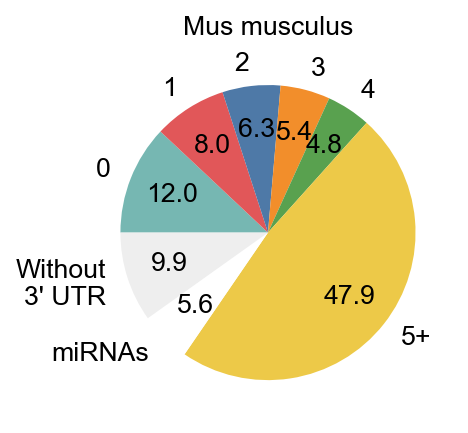

In [17]:
df = pd.read_csv(PREFIX + "combined_pre_expansion_fig.csv")
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
patches, texts, autotexts = draw_pie(ax, df, label_size=12, field="frac_all_genes")
ax.set_title("Mus musculus")
fig.tight_layout()
fig.savefig(PREFIX + "Fig 1b.svg", dpi=300)

# Supplementary Figure 2h

In [10]:
# In S2h we pull all the tricks, combining CCA/GCA/TCA/CAA variants:
# - for the UTR @ 90 bp +
# - for the UTR @ 72 bp +
# - for the CDS @ 90 bp + 
# - for the CDS @ 72 bp + 
# - for the UTR @ 36 + 54 bp +
# - for the CDS @ 36 bp + 54 bp @ UTR +
combined_figS2h = combine_candidates([
    all_candidates_by_gene[(variant, 90, "3UTR")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    all_candidates_by_gene[(variant, 72, "3UTR")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    all_candidates_by_gene[(variant, 90, "CDS")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    all_candidates_by_gene[(variant, 72, "CDS")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    process_split_cbg(all_candidates_by_gene[(variant, 36, "3UTR")], all_candidates_by_gene[("NNN", 54, "3UTR")], 36 + 54, "3UTR-3UTR") for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    process_split_cbg(all_candidates_by_gene[(variant, 36, "CDS")], all_candidates_by_gene[("NNN", 54, "3UTR")], 36 + 54, "CDS-3UTR") for variant in ("CCA", "GCA", "TCA", "CAA")
], by_gene_cds)

In [27]:
write_candidate_table(combined_figS2h, f"{PREFIX}{ORGANISM}_RADAR_sensor_candidates.csv.gz")

writing 3264017 candidates
19977 unique genes


In [12]:
df = analyze_candidates_by_gene(
    by_gene_cds, combined_figS2h, PREFIX + "combined_figS2h.csv", utr_genes=common, verbose=True,
    exclude_non3utrs=False,
)

1209.0 == 1209 miRNAs are 5.6% of the dataset
469 with 0 candidates (2.2%) of all genes, 2.3% of genes with annotated 3' UTRs)
19977 with 1+ candidates (92.3% of all genes, 97.7% of genes with annotated 3' UTRs)
19373 have >= 5 candidates (89.5% of all genes, 94.8% of genes with annotated 3' UTRs)
    num   ct  frac_all_genes  frac_genes_with_utr
0     0  469        0.021658             0.022938
1     1  170        0.007850             0.008315
2     2  150        0.006927             0.007336
3     3  134        0.006188             0.006554
4     4  150        0.006927             0.007336
5     5  122        0.005634             0.005967
6     6  112        0.005172             0.005478
7     7   96        0.004433             0.004695
8     8  104        0.004803             0.005087
9     9   99        0.004572             0.004842
10   10  102        0.004710             0.004989
          num    ct  frac_all_genes  frac_genes_with_utr
1016    12516     1        0.000046         

In [13]:
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].ct.sum())
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].frac_all_genes.sum())

19977
0.9225121219117987


In [14]:
df.ct.sum()

21655

['0', '1-5', '6-50', '51+', 'miRNAs'] [0.02165781574694066, 0.03352574463172478, 0.21477718771646268, 0.6742091895636113, 0.05583006234126068] 1.0


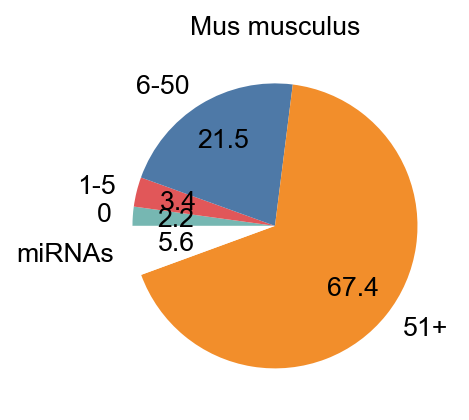

In [15]:
df = pd.read_csv(PREFIX + "combined_figS2h.csv")
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
patches, texts, autotexts = draw_pie_grouped(ax, df, groups=("0-0", "1-5", "6-50", "51-inf"), label_size=12, field="frac_all_genes")
ax.set_title("Mus musculus")
fig.tight_layout()
fig.savefig(PREFIX + "Fig 2d.svg", dpi=300)

## Ones without any candidates

In [17]:
no_candidates = sorted([gene for gene in by_gene_cds if len(combined_figS2h.get(gene, [])) == 0 and not gene.lower().startswith("mir")])

In [18]:
len(no_candidates)

469

In [19]:
print_gene_prefixes(no_candidates)

IGKV	65	13.9%
TRAJ	51	10.9%
IGHV	47	10.0%
H	45	9.6%
OLFR	41	8.7%
IGHD	17	3.6%
RPL	17	3.6%
TRAV	13	2.8%
TRBJ	13	2.8%
RPS	12	2.6%
MT	8	1.7%
KRTAP	7	1.5%
EIF	5	1.1%
IGKJ	5	1.1%
VMN	5	1.1%
IFNA	4	0.9%
IGHJ	4	0.9%
IGLJ	4	0.9%
TRGJ	4	0.9%
COX	3	0.6%
DEFA	3	0.6%
ZFP	3	0.6%
ATP	2	0.4%
BTBD	2	0.4%
DEFB	2	0.4%
NDUFA	2	0.4%
PSME	2	0.4%
SAMT	2	0.4%
SPIN	2	0.4%
TAAR	2	0.4%


453.3280116110305


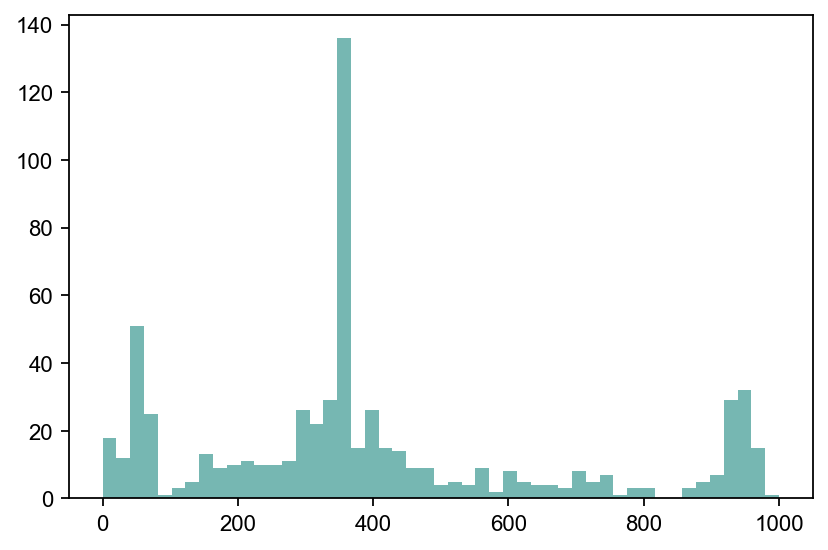

In [20]:
cds_lengths = []
for gene in no_candidates:
    for cds in by_gene_cds[gene].values():
        cds_lengths.append(len(cds.seq))
fig, ax = plt.subplots()
ax.hist(cds_lengths, bins=np.linspace(0, 1000, 50))
print(np.mean(cds_lengths))

79.19072847682119


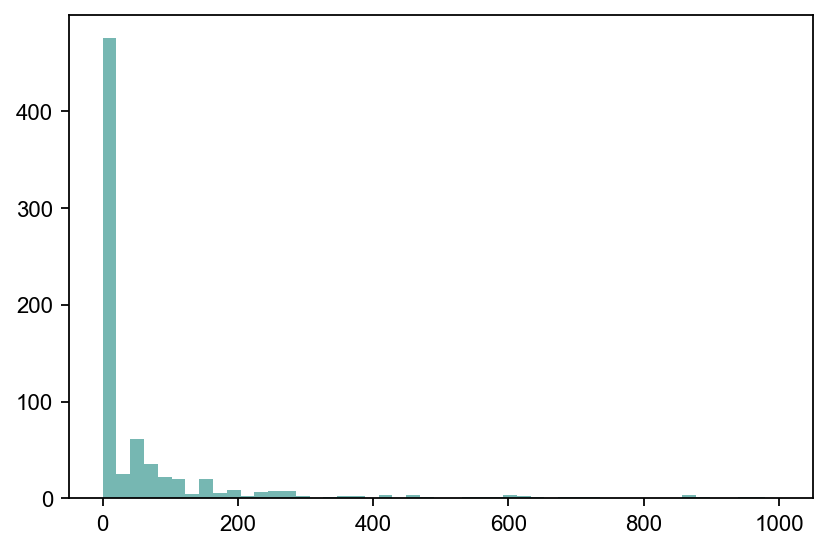

In [21]:
utr_lengths = []
for gene in no_candidates:
    utrs = by_gene_3utr.get(gene, dict()).values()
    for utr in utrs:
        utr_lengths.append(len(utr.seq))
    else:
        utr_lengths.append(0)
fig, ax = plt.subplots()
ax.hist(utr_lengths, bins=np.linspace(0, 1000, 50))
print(np.mean(utr_lengths))

# Incremental benefits

In [22]:
df = pd.read_csv(PREFIX + "candidates_figS2h.csv.gz")

(90, '3UTR')	15712	+72.6%	72.6%
(72, '3UTR')	17114	+6.5%	79.0%
(90, 'CDS')	19537	+11.2%	90.2%
(72, 'CDS')	19848	+1.4%	91.7%
(90, '3UTR-3UTR')	19904	+0.3%	91.9%
(90, 'CDS-3UTR')	19977	+0.3%	92.3%


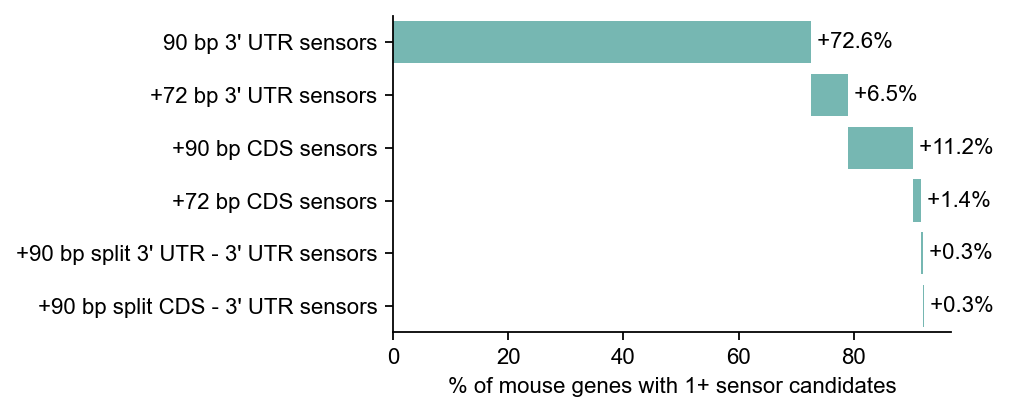

In [24]:
using_combos = []
combos = [
    (90, "3UTR"),
    (72, "3UTR"),
    (90, "CDS"),
    (72, "CDS"),
    (90, "3UTR-3UTR"),
    (90, "CDS-3UTR"),
]
n_genes = len(by_gene_cds)
gb = df.groupby(["length", "region_type"])
fig, ax = plt.subplots(figsize=(4.5, 2.62))
prev = 0
for i, combo in enumerate(combos):
    using_combos.append(combo)
    genes = set()
    for this_combo in using_combos:
        genes |= set(gb.get_group(this_combo).gene)
    n = len(genes)
    incremental = (n - prev) / n_genes * 100
    print(f"{combo}\t{n}\t+{incremental:.1f}%\t{n / n_genes:.1%}")
    ax.barh(i, incremental, left=prev / n_genes * 100, color=TABLEAU_10["light teal"])
    ax.text(n / n_genes * 100, i, f" +{incremental:.1f}%", verticalalignment="center")
    prev = n
ax.set_ylim(len(combos) - 0.5, -0.5)
ax.set_yticks(range(len(combos)))
ax.set_yticklabels([
    "90 bp 3' UTR sensors",
    "+72 bp 3' UTR sensors",
    "+90 bp CDS sensors",
    "+72 bp CDS sensors",
    "+90 bp split 3' UTR - 3' UTR sensors",
    "+90 bp split CDS - 3' UTR sensors",
])
ax.set_xlabel(f"% of {ORGANISM} genes with 1+ sensor candidates")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(PREFIX + "incremental benefits.svg")